## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

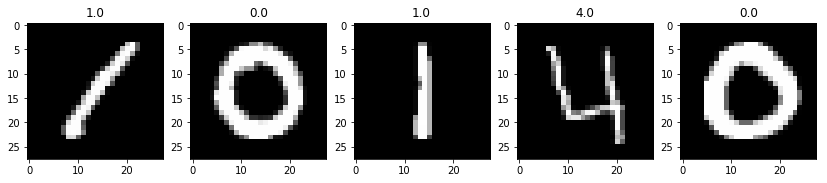

In [4]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [7]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [9]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [10]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

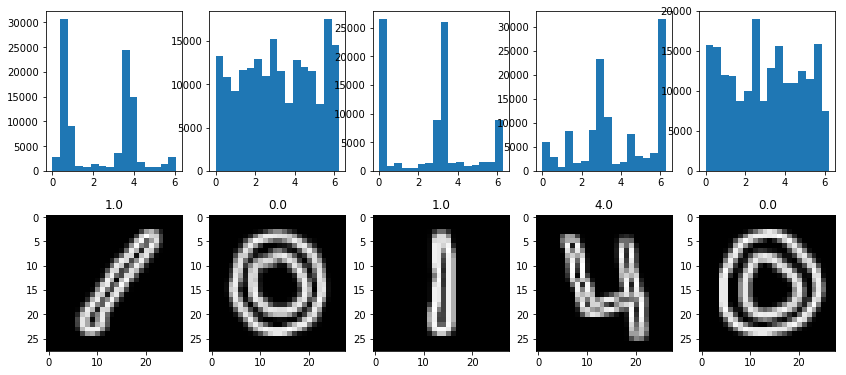

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [12]:
def blockshaped(arr, nrows, ncols):
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


In [49]:
# Гистограммы вычисляются с учетом длины вектора градиента
# Делим изображение на 4 участка 14*14
# 28*7
train_hist = np.zeros((len(train_img), 4,16))
hist_slices = np.zeros((4,16))
for i in range(len(train_img)):
    theta_sclices = blockshaped(train_theta[i],14,14)
    g_clices = blockshaped(train_g[i],14,14)
    for n in range(4):
        hist_slices[n], borders = np.histogram(theta_sclices[n],
                                         bins=16,
                                         range=(0., 2. * np.pi),
                                         weights=g_clices[n])
    hist = hist_slices 
    train_hist[i] = hist

In [50]:
test_hist = np.zeros((len(test_img), 4,16))
hist_slices_test = np.zeros((4,16))
for i in range(len(test_img)):
    theta_sclices_test = blockshaped(test_theta[i],14,14)
    g_clices_test = blockshaped(test_g[i],14,14)
    for n in range(4):
        hist_slices_test[n], borders = np.histogram(theta_sclices_test[n],
                                     bins=16,
                                     range=(0., 2. * np.pi),
                                     weights=g_clices_test[n])
    hist = hist_slices_test    
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [52]:
# По умолчанию используется L2 норма
train_hist = train_hist.reshape(42000,64)
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [53]:
train_hist.shape

(42000, 64)

In [54]:
test_hist = test_hist.reshape(28000,64)
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

##  Тренируем классификатор

In [62]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

/Users/dmitryfilipsky/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [63]:
clf=xgb.XGBClassifier()
paramgrid = {'max_depth': [1,2,3], 'n_estimators': [50,100,150]}
grid_search = GridSearchCV(estimator=clf, param_grid=paramgrid, cv=5, scoring = 'neg_log_loss', verbose=10)

In [82]:
grid_search.fit(X=train_hist, y=train_label)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=1, n_estimators=50 ....................................
[CV]  max_depth=1, n_estimators=50, score=-0.9001549601608058, total=   3.6s
[CV] max_depth=1, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  max_depth=1, n_estimators=50, score=-0.9080164836575328, total=   3.6s
[CV] max_depth=1, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV]  max_depth=1, n_estimators=50, score=-0.9016135673886155, total=   3.6s
[CV] max_depth=1, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s


[CV]  max_depth=1, n_estimators=50, score=-0.9012220318053071, total=   3.5s
[CV] max_depth=1, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.8s remaining:    0.0s


[CV]  max_depth=1, n_estimators=50, score=-0.9054564493129287, total=   3.6s
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.5s remaining:    0.0s


[CV]  max_depth=1, n_estimators=100, score=-0.5708781157183123, total=   7.0s
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   25.8s remaining:    0.0s


[CV]  max_depth=1, n_estimators=100, score=-0.57625190308312, total=   7.2s
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   33.1s remaining:    0.0s


[CV]  max_depth=1, n_estimators=100, score=-0.5727581000704008, total=   7.4s
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   40.7s remaining:    0.0s


[CV]  max_depth=1, n_estimators=100, score=-0.571582312117723, total=   7.5s
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   48.4s remaining:    0.0s


[CV]  max_depth=1, n_estimators=100, score=-0.570745084149006, total=   7.8s
[CV] max_depth=1, n_estimators=150 ...................................
[CV]  max_depth=1, n_estimators=150, score=-0.4269976764327887, total=  11.8s
[CV] max_depth=1, n_estimators=150 ...................................
[CV]  max_depth=1, n_estimators=150, score=-0.43083963799487085, total=  11.7s
[CV] max_depth=1, n_estimators=150 ...................................
[CV]  max_depth=1, n_estimators=150, score=-0.42910597084065943, total=  11.8s
[CV] max_depth=1, n_estimators=150 ...................................
[CV]  max_depth=1, n_estimators=150, score=-0.428241079689475, total=  11.8s
[CV] max_depth=1, n_estimators=150 ...................................
[CV]  max_depth=1, n_estimators=150, score=-0.4249312258170223, total=  11.5s
[CV] max_depth=2, n_estimators=50 ....................................
[CV]  max_depth=2, n_estimators=50, score=-0.48567648222165793, total=   7.1s
[CV] max_depth=2, n_estimato

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 10.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3], 'n_estimators': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=10)

## Предсказания на тестовых данных

In [88]:
pred_test = np.zeros(len(test_img), np.uint8)
pred_test = grid_search.best_estimator_.predict(test_hist)

## Визуализируем предсказания

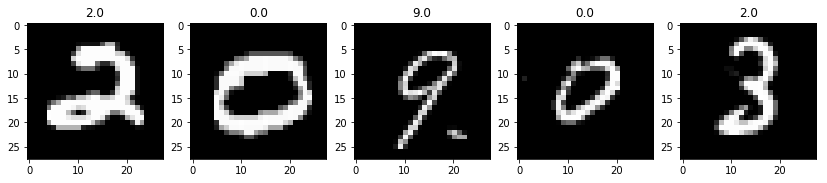

In [90]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [92]:
with open('submit_hog_xgb.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [93]:
# Your submission scored 0.96014